# Dependencies

In [1]:
import numpy as np
import torch
import torch_geometric as pyg

from torch_geometric_temporal.signal import StaticGraphTemporalSignal

# Overview 
The following functions will allow you to convert a Pytorch Geometric Data object along with a batch of temporal data into a Pytorch Geometric Temporal StaticGraphTemporalSignal object. 

In [27]:
def merge_dynamic_with_static_features(static_features: np.array, dynamic_features: np.array) -> np.array:
    """
    Merges values of dynamic features with values of static features across a batch. The static features 
    are broadcasted, instead of being copied, (due to staying unchanged throughout the batch) to save
    memory.
    
    static_feature: array of values of features that do not change throughout the spatial domain of the 
    batch.
    batch: array of values of features that do change throughout the spatial domain of the batch.
    """
    return np.concatenate(
        (np.broadcast_to(static_features, (len(dynamic_features), *static_features.shape)),
         np.expand_dims(dynamic_features, axis=-1)), 
        axis=-1)


def make_static_graph_temporal_signal(data: pyg.data.Data, dynamic_features: np.array) -> \
StaticGraphTemporalSignal:
    """
    Creates a Pytorch Geometric Temporal StaticGraphTemporalSignal object from a Pytoroch Geometric data 
    object and an array of values of features that vary across time. 
    The 'targets' attribute for a given snapshot of the returned object are exactly the features of the 
    subsequent snapshot.
    
    data: Pytorch Geometric data instance representing a graph and its static features. 
    dynamic_features: array of values of features of the nodes of the graph in data that change through
    time. 
    """

    edge_index = data.edge_index.type(torch.long)
    edge_weight = data.edge_attr.type(torch.float)

    features = merge_dynamic_with_static_features(
        static_features=data.x.numpy(), dynamic_features=dynamic_features)

    # Set targets to be the features of the subsequent snapshots
    targets = features[1:, :, -1]
    features = features[:-1]

    # The pos array is assumed not to change, so it may be broadcasted instead of being copied
    pos = data.pos.numpy()
    pos = np.broadcast_to(pos, (len(dynamic_features) - 1, *pos.shape))

    # additional features
    kwargs = {
        'pos': pos
    }

    return StaticGraphTemporalSignal(
        edge_index=edge_index,
        edge_weight=edge_weight,
        features=features,
        targets=targets,
        **kwargs,
    )

# Example

In [34]:
import osmnx as ox 
import numpy as np

from osmnx_to_pyg import osmnx_to_pyg
from matplotlib import pyplot as plt

In [51]:
G = ox.graph_from_place('New Delhi')
data = osmnx_to_pyg(G=G)

# Generate random features for nodes in G
N_TIMESTEPS = 11
n_nodes = len(data.x)
rng = np.random.default_rng(seed=0)
dynamic_features=rng.normal(size=(N_TIMESTEPS, n_nodes))

pygt_data = make_static_graph_temporal_signal(data, dynamic_features)

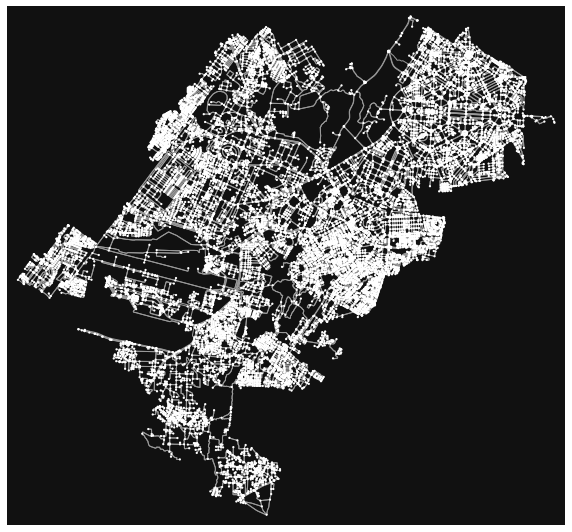

In [37]:
ox.plot_graph(G, node_size=5, figsize=(10, 10));

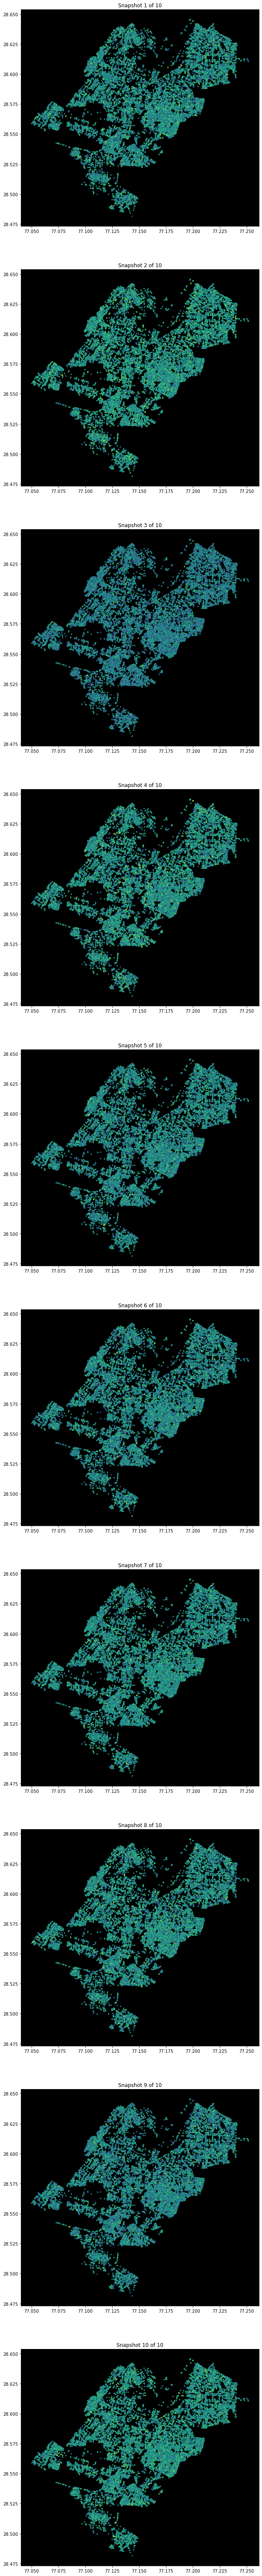

In [56]:
# Note that the length of the StaticGraphTemporalSignal object will be one less than N_TIMESTEPS, since 
# we need one timestep of difference between features and targets for each snapshot.
fig, axes = plt.subplots(N_TIMESTEPS-1, 1, figsize=(10, 11*(N_TIMESTEPS-1)))

for ax, timestep, snapshot in zip(axes, range(1, N_TIMESTEPS), pygt_data):
    ax.scatter(*snapshot.pos.T, c=snapshot.x, s=5)
    ax.set_title(f"Snapshot {timestep} of {N_TIMESTEPS-1}")
    ax.set_facecolor('k')